In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np  
import datetime 

train = pd.read_csv('/content/drive/MyDrive/Pharmaceutical_Sales_prediction/data/com_train.csv', index_col=0)
# store = pd.read_csv('/content/drive/MyDrive/Pharmaceutical_Sales_prediction/data/store.csv')
test = pd.read_csv('/content/drive/MyDrive/Pharmaceutical_Sales_prediction/data/com_test.csv') 


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# Load the Data* and Make Transformations

In [9]:
scaler = MinMaxScaler()
# train = train[['date','Sales']]
train = train.loc[:,['Sales']]
train

,Sales
Date,
2013-01-01,0
2013-01-02,5530
2013-01-03,4327
2013-01-04,4486
2013-01-05,4997
...,...
2015-07-27,10712
2015-07-28,8093
2015-07-29,7661


In [10]:
scaler.fit(train.Sales.values.reshape([-1, 1]))
trainScaled = scaler.transform(train.Sales.values.reshape(-1, 1))
train['SalesScaled'] = trainScaled
train.tail(10)

,Sales,SalesScaled
Date,,
2015-07-22,5342,0.128565
2015-07-23,6150,0.148011
2015-07-24,5816,0.139973
2015-07-25,6897,0.165989
2015-07-26,0,0.000000
2015-07-27,10712,0.257804
2015-07-28,8093,0.194773
2015-07-29,7661,0.184376
2015-07-30,8405,0.202282


# Descriptive Statistics and Visualizations of the Data.


In [11]:
train.describe()

,Sales,SalesScaled
count,1.017209e+06,1.017209e+06
mean,5.773819e+03,1.389574e-01
std,3.849926e+03,9.265544e-02
min,0.000000e+00,0.000000e+00
25%,3.727000e+03,8.969700e-02
50%,5.744000e+03,1.382398e-01
75%,7.856000e+03,1.890689e-01
max,4.155100e+04,1.000000e+00


In [12]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

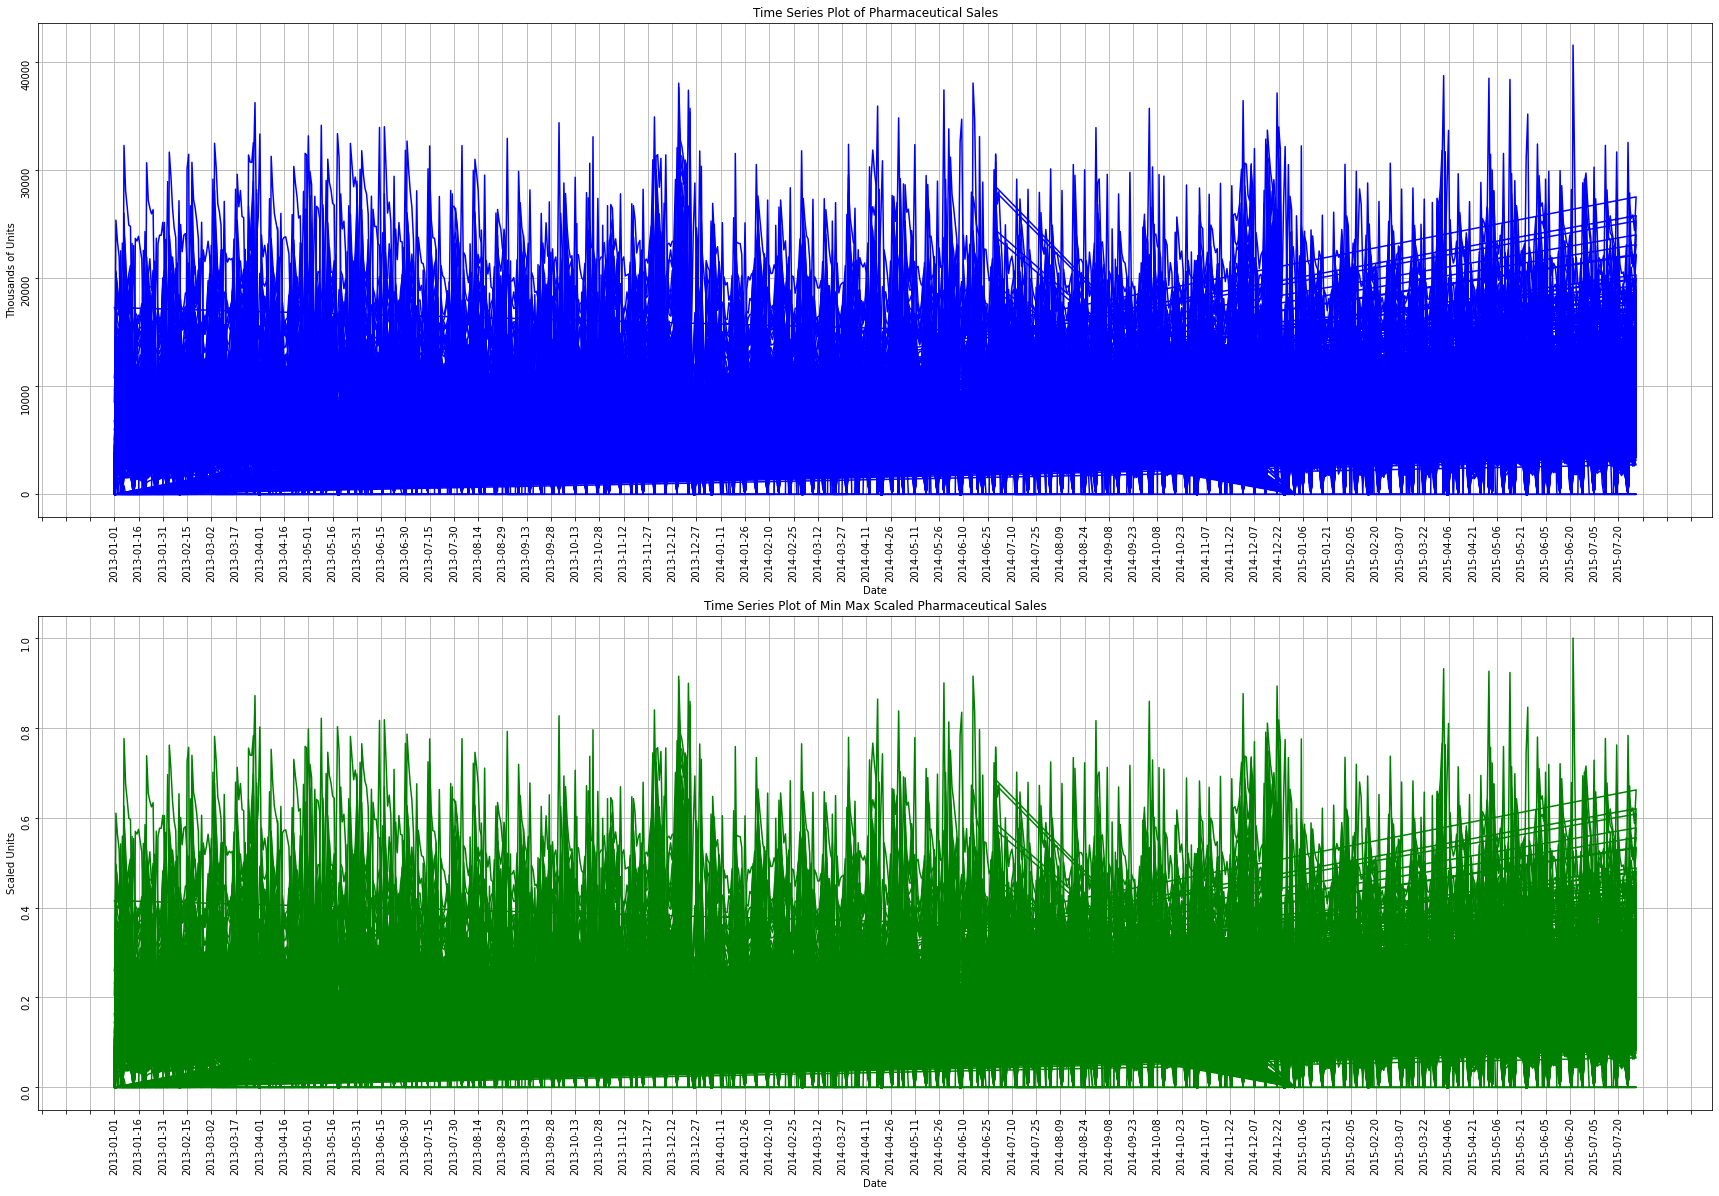

In [13]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(train.index, train.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of Pharmaceutical Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(train.index, train.SalesScaled, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Scaled Pharmaceutical Sales')
ax2.grid(True)
plt.show()

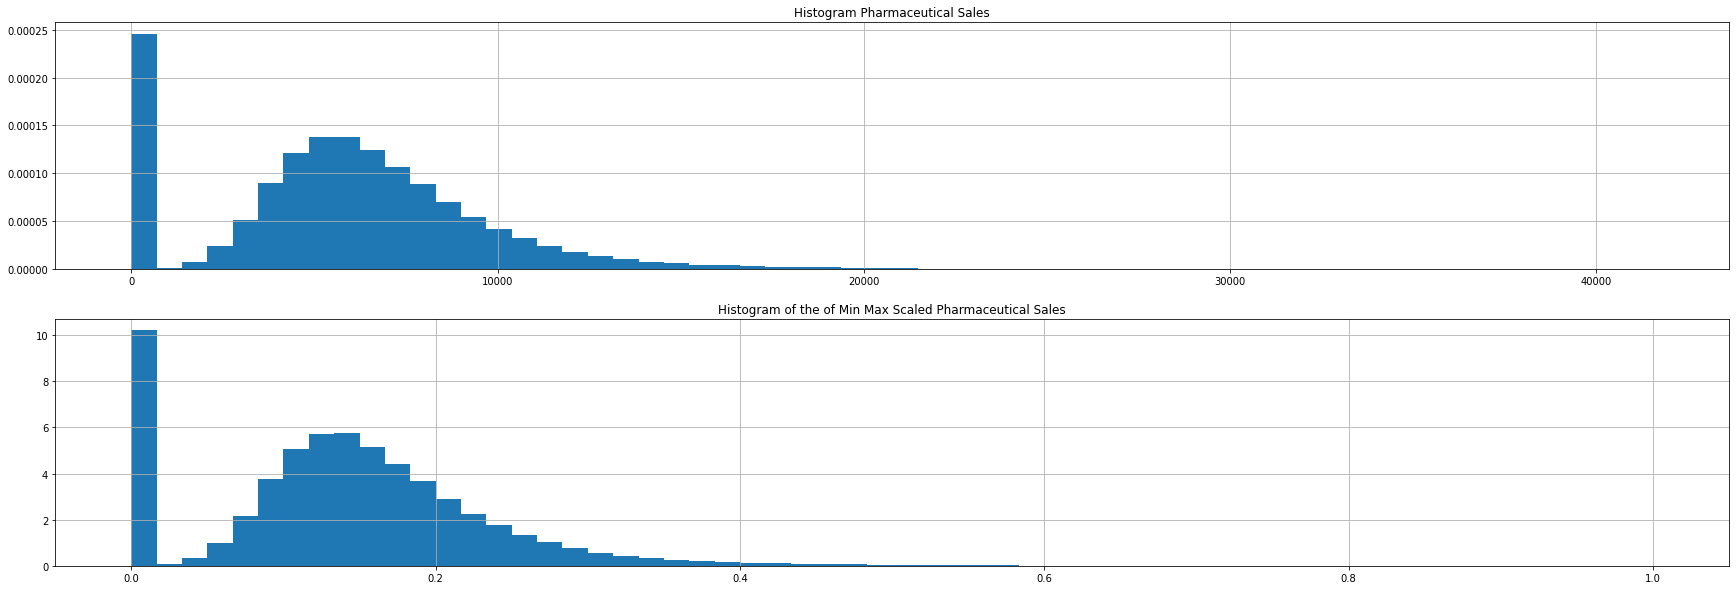

In [14]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(train.Sales, density=True, bins=60)
ax1.title.set_text('Histogram Pharmaceutical Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(train.SalesScaled, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled Pharmaceutical Sales')
ax2.grid(True)
plt.show()

# Unit Root Tests.

In [15]:
train = train[train['Sales'] != 0]  #Drops samples which have sales more than 25000
train.reset_index(drop=True)

,Sales,SalesScaled
0,5530,0.133089
1,4327,0.104137
2,4486,0.107964
3,4997,0.120262
4,7176,0.172703
...,...,...
844333,10712,0.257804
844334,8093,0.194773
844335,7661,0.184376
844336,8405,0.202282


In [16]:
train = train[train['Sales'] < 25000]  #Drops samples which have sales more than 25000
train.reset_index(drop=True)

,Sales,SalesScaled
0,5530,0.133089
1,4327,0.104137
2,4486,0.107964
3,4997,0.120262
4,7176,0.172703
...,...,...
843574,10712,0.257804
843575,8093,0.194773
843576,7661,0.184376
843577,8405,0.202282


In [18]:
trains = train.loc[:,['Sales']]
trains = trains.iloc[:10000, :]
trains

,Sales
Date,
2013-01-02,5530
2013-01-03,4327
2013-01-04,4486
2013-01-05,4997
2013-01-07,7176
...,...
2015-07-16,5921
2015-07-17,5740
2015-07-18,4956


In [20]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
adfResult = adfuller(trains.Sales.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -5.182223528754638
p-value: 9.55730702137053e-06


In [ ]:
# adfResult = adfuller(trains.SalesScaled.values, autolag='AIC')
# print(f'ADF Statistic: {adfResult[0]}')
# print(f'p-value: {adfResult[1]}')